<a href="https://colab.research.google.com/github/maherabbass/DataScienceModels/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Image classification

## Instructions

In this assignment, you will be working on the COVID-19 lung X-Ray dataset. It consists of X-ray images that are labeled as either "Normal" or "Covid", with the latter indicating an X-ray of a COVID-19 patient.

To predict if a person has COVID or not, you will train the following five different classification models, finetune their hyperparameters, and finally select the best model and test it on the test data.

1.   Decision Tree
2.   Gradient Boosting
3.   Random Forest
4.   Support Vector Machines
5.   Neural Netwroks

The dataset can be found here: [Covid 19 X-Ray Dataset](https://drive.google.com/drive/folders/1Nwa6L58NwF23PvImpDrp-W8oTOheu_b3?usp=sharing). The data is already split into training, validation, and test.

To help you with this assignment, you are provided some instructions to follow, we will be checking those criteria when evaluating your submissions.

## Part 1: Data Exploration

In [1]:
# load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# define the path for training, testing and validation datasets
train_dir = "/content/drive/MyDrive/Dataset/Training"
val_dir = "/content/drive/MyDrive/Dataset/Validation"
test_dir = "/content/drive/MyDrive/Dataset/Testing"

Since we are dealing with folders and subfolders, it's crucial to use the os library so that we will be able to use the

```
# os.path.join(folder, 'destination directory name')
```

where the destination will be either "COVID" or "Normal".



In [3]:
# import libaries
import os

# Function to count samples in each folder
def count_samples(folder):
    covid_path = os.path.join(folder, 'COVID')
    normal_path = os.path.join(folder, 'Normal')
    num_covid = len(os.listdir(covid_path))
    num_normal = len(os.listdir(normal_path))
    return num_covid, num_normal

# count samples in each folder
train_covid, train_normal = count_samples(train_dir)
test_covid, test_normal = count_samples(test_dir)
val_covid, val_normal = count_samples(val_dir)

# output the counts
print("Number of samples in each folder:")
print("Number of samples in each folder:")
print("Training - COVID:", train_covid)
print("Training - Normal:", train_normal)
print("Validation - COVID:", val_covid)
print("Validation - Normal:", val_normal)
print("Testing - COVID:", test_covid)
print("Testing - Normal:", test_normal)

Number of samples in each folder:
Number of samples in each folder:
Training - COVID: 200
Training - Normal: 200
Validation - COVID: 50
Validation - Normal: 50
Testing - COVID: 25
Testing - Normal: 25


Your next step is to visualize some of the data that you have. When we were dealing with a dataframe, it was easier for us to visualize some samples since the dataframe have a head and many other functions to get the job done.

In our case, we are dealing with images. The simplest option is to check the folder from your drive but we need to see it inside the model here.

To do that, you should use the cv2 library and use the method

```
cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
```
so that we can read an image that is in grayscale.


In addition, the image should be in a viewable format, so we need to plot then show the image using the matplotlib library.


Visualizing 2 COVID images from Training folder:


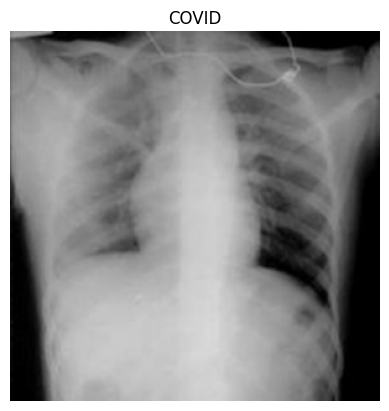

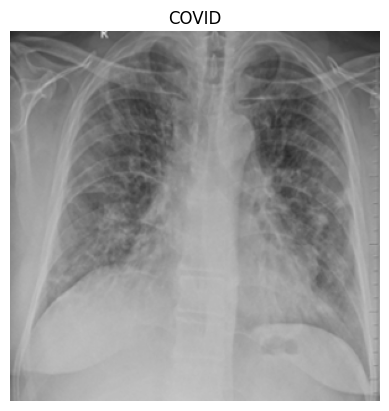


Visualizing 2 Normal images from Training folder:


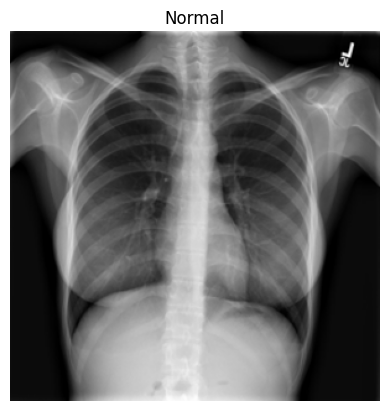

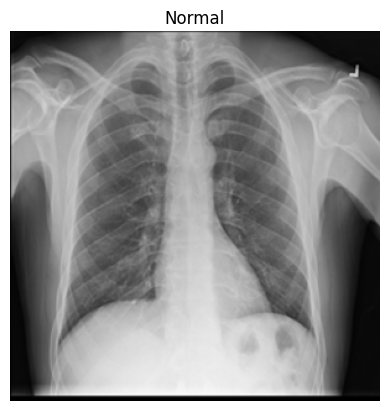


Visualizing 2 COVID images from Testing folder:


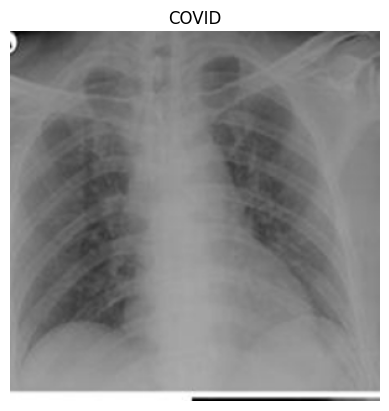

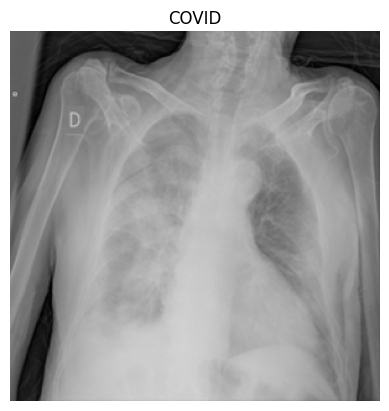


Visualizing 2 Normal images from Testing folder:


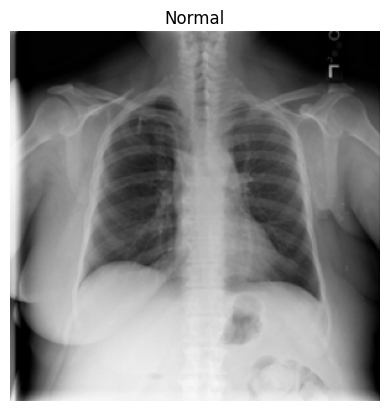

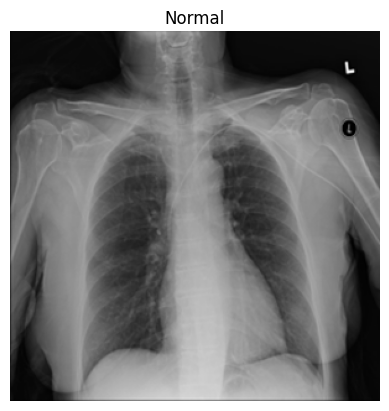


Visualizing 2 COVID images from Validation folder:


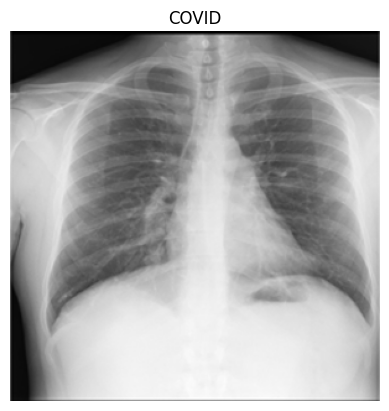

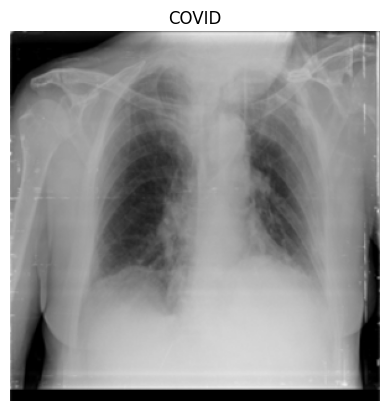


Visualizing 2 Normal images from Validation folder:


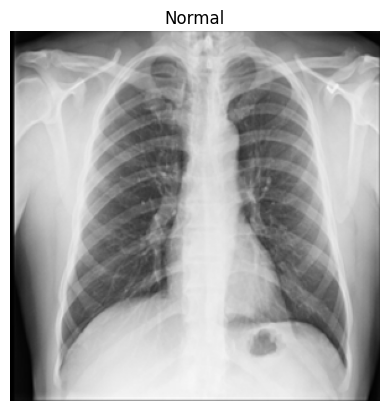

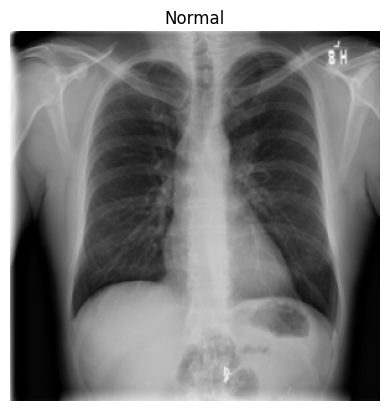

In [4]:
# import libaries
import cv2
import matplotlib.pyplot as plt

# function to visualize images from each folder
def visualize_images(folder, label, num_samples=2):
    covid_path = os.path.join(folder, 'COVID')
    normal_path = os.path.join(folder, 'Normal')

    # visualize COVID images
    covid_images = os.listdir(covid_path)[:num_samples]
    print(f"\nVisualizing {num_samples} COVID images from {label} folder:")
    for img_name in covid_images:
        img_path = os.path.join(covid_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("COVID")
        plt.axis('off')
        plt.show()

    # visualize Normal images
    normal_images = os.listdir(normal_path)[:num_samples]
    print(f"\nVisualizing {num_samples} Normal images from {label} folder:")
    for img_name in normal_images:
        img_path = os.path.join(normal_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Normal")
        plt.axis('off')
        plt.show()

# visualize images from each folder
visualize_images(train_dir, "Training")
visualize_images(test_dir, "Testing")
visualize_images(val_dir, "Validation")

## Part 2: Data Preparation

Since we are dealing with images and folders, and since we know that we do not have a dataframe to choose from, we need to present our folders and images in a suitable format for the different models.

To do that, we will be use the method

```
load_images_from_folder()
```
that will take as parameters the folder path and the label, and return 2 arrays, one for the features (which are the images) and one for the labels.

To build this method, we need at first to initiate 2 empty arrays to hold the new values that we will be working with and we need to make a dictionnary to map the labels COVID and Normal to numeric values (0 and 1).

Next, we need to loop over the images inside each folder and do the following:

1.   Read the image
2.   Convert each image to grayscale
3.   Normalize the pixels values between 0 and 1
4.   Flatten the image
5.   Append the image and its label to the correspondng arrays


In [5]:
# import libaries
import numpy as np

def load_images_from_folder(folder_path, label, target_size=(100, 100)):
    images = []
    labels = []
    label_dict = {'COVID': 0, 'Normal': 1}  # Define a dictionary to map labels to numeric values
    label_code = label_dict[label]

    label_path = os.path.join(folder_path, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        # load the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
        # resize the image
        img_resized = cv2.resize(img, target_size)  # Resize the image to the specified target size
        # preprocess the resized image (e.g., normalize pixel values)
        img_resized = img_resized.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        # flatten the resized image
        img_flat = img_resized.flatten()
        # append the flattened image and corresponding label
        images.append(img_flat)
        labels.append(label_code)
    return np.array(images), np.array(labels)


Next, call this method for all the folders you have to prepare your data for training.

In [6]:
# load images from the training folder for both COVID and Normal labels
train_covid_images, train_covid_labels = load_images_from_folder(train_dir, 'COVID')
train_normal_images, train_normal_labels = load_images_from_folder(train_dir, 'Normal')

# load images from the testing folder for both COVID and Normal labels
test_covid_images, test_covid_labels = load_images_from_folder(test_dir, 'COVID')
test_normal_images, test_normal_labels = load_images_from_folder(test_dir, 'Normal')

# load images from the validation folder for both COVID and Normal labels
val_covid_images, val_covid_labels = load_images_from_folder(val_dir, 'COVID')
val_normal_images, val_normal_labels = load_images_from_folder(val_dir, 'Normal')

In [7]:
train_covid_images.shape

(200, 10000)

In [8]:
# combine COVID and Normal images and labels for training, validation and test
train_images = np.concatenate((train_covid_images, train_normal_images), axis=0)
train_labels = np.concatenate((train_covid_labels, train_normal_labels), axis=0)

val_images = np.concatenate((val_covid_images, val_normal_images), axis=0)
val_labels = np.concatenate((val_covid_labels, val_normal_labels), axis=0)

test_images = np.concatenate((test_covid_images, test_normal_images), axis=0)
test_labels = np.concatenate((test_covid_labels, test_normal_labels), axis=0)


## Part 3: Models


### Decision Tree

Train a Decision Tree model using the default hyperparameters and evaluate its performance on the validation set

In [9]:
# import libaries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# initialize and train the decision tree model
'''enter your code here'''
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_images, train_labels)

# predict labels for the validation set
'''enter your code here'''
val_predictions = dt_classifier.predict(val_images)

# report the validation accuracy of the trained model
'''enter your code here'''
validation_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {validation_accuracy}")

Validation Accuracy: 0.86


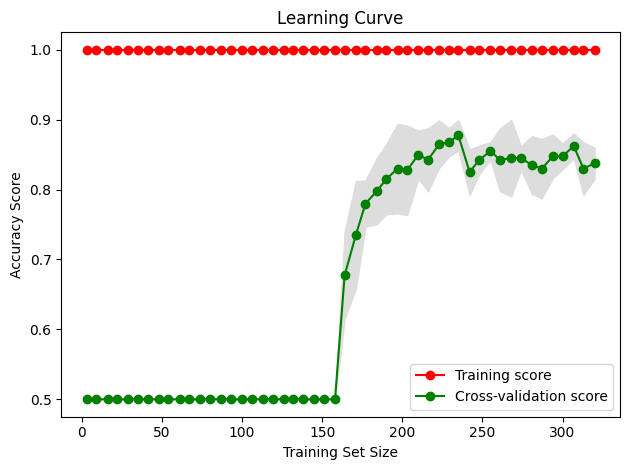

In [10]:
# plot the learning curve of the trained model to examine bias and variance
#import libraries
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

'''enter your code here'''
train_sizes, train_scores, validation_scores = learning_curve(
    DecisionTreeClassifier(), train_images, train_labels, cv=5,
    scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))

# Mean and standard deviation for train set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

Answer:
The model does not suffer from underfitting since both training and validation scores are high. There is a slight overfitting since the training score is near perfect while the validation score is slightly lower, but it's not severe because the validation score is still high.

#### Hyperparameter tuning

Use the **GridSearchCV** module of the **sklearn** library to tune the hyperparameter of your Decision Tree model on the validation set. You should try to tune as many hyperparameters as you can, such as split criterion, maximum depth, etc. Your tuning should be guided by the observations you made from the learning curve of the untuned model.   

In [11]:
# code Here
from sklearn.model_selection import GridSearchCV

# Parameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(val_images, val_labels)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'criterion': 'gini',
  'max_depth': 8,
  'min_samples_leaf': 4,
  'min_samples_split': 5},
 0.93)

### Gradient Boosting

Train a Gradient Boosting model using the default hyperparameters and validate it on the validation set.



In [10]:
# import libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# initialize and train the Gradient Boosting model
'''enter your code here'''
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(train_images, train_labels)

# predict labels for the validation set
'''enter your code here'''
val_predictions_gb = gb_classifier.predict(val_images)

# report the validation accuracy of the trained model
'''enter your code here'''
validation_accuracy_gb = accuracy_score(val_labels, val_predictions_gb)
print(f"Validation Accuracy: {validation_accuracy_gb}")

Validation Accuracy: 0.94


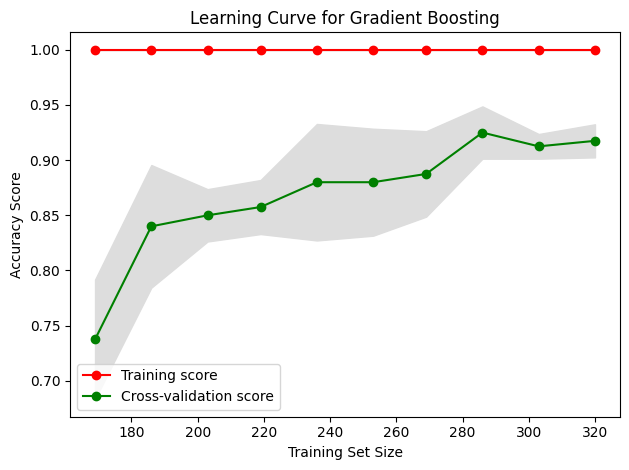

0.94

In [11]:
# plot the learning curve of the trained model to examine bias and variance
'''enter your code here'''
#import libraries
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Plotting the learning curve
train_sizes_gb, train_scores_gb, validation_scores_gb = learning_curve(
    GradientBoostingClassifier(), train_images, train_labels, cv=5,
    scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 20))

# Mean and standard deviation for train set scores
train_mean_gb = np.mean(train_scores_gb, axis=1)
train_std_gb = np.std(train_scores_gb, axis=1)

# Mean and standard deviation for validation set scores
validation_mean_gb = np.mean(validation_scores_gb, axis=1)
validation_std_gb = np.std(validation_scores_gb, axis=1)

plt.fill_between(train_sizes_gb, train_mean_gb - train_std_gb, train_mean_gb + train_std_gb, color="#DDDDDD")
plt.fill_between(train_sizes_gb, validation_mean_gb - validation_std_gb, validation_mean_gb + validation_std_gb, color="#DDDDDD")

plt.plot(train_sizes_gb, train_mean_gb, 'o-', color="r", label="Training score")
plt.plot(train_sizes_gb, validation_mean_gb, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for Gradient Boosting")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

validation_accuracy_gb

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

Answer:\
The model does not appear to suffer from underfitting (high bias) as both the training and cross-validation scores are high, which indicates that the model has learned the patterns in the data effectively.

There is a small gap between the training and cross-validation scores, suggesting a slight overfitting (high variance), as the model performs better on the training data than on the unseen validation data. However, the high validation accuracy (94%) means the model is still generalizing well to new data. Therefore, while there might be a slight overfitting, it does not seem to be a significant issue for this model given the current data.

#### Hyperparameter tuning

Use the **GridSearchCV** module of the **sklearn** library to tune the hyperparameter of your Gradient Boosting model on the validation set. You should try to tune as many hyperparameters as you can, such as criterion, maximum depth, learning rate, number of estimators, etc. Your tuning should be guided by the observations you made from the learning curve of the untuned model.

In [ ]:
# code Here
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters for tuning
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 3, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the GridSearchCV object for Gradient Boosting Classifier
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_gb.fit(val_images, val_labels)

# Output the best parameters and the corresponding score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

### Random Forest

Train a Random Forest model using the default hyperparameters and validate it on the validation set.


In [14]:
# import libaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# initialize and train the Random Forest model
'''enter your code here'''
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_images, train_labels)

# predict labels for the validation set
'''enter your code here'''
val_predictions_rf = rf_classifier.predict(val_images)

# report the validation accuracy of the trained model
'''enter your code here'''
validation_accuracy_rf = accuracy_score(val_labels, val_predictions_rf)
print(f"Validation Accuracy: {validation_accuracy_rf}")

Validation Accuracy: 0.94


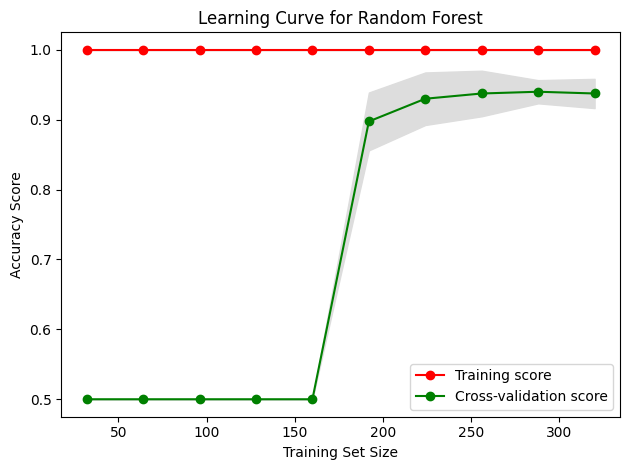

0.94

In [15]:
# plot the learning curve of the trained model to examine bias and variance
'''enter your code here'''
#import libraries
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Plotting the learning curve
train_sizes_rf, train_scores_rf, validation_scores_rf = learning_curve(
    RandomForestClassifier(),
    train_images, train_labels,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Mean and standard deviation for train set scores
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)

# Mean and standard deviation for validation set scores
validation_mean_rf = np.mean(validation_scores_rf, axis=1)
validation_std_rf = np.std(validation_scores_rf, axis=1)

plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, color="#DDDDDD")
plt.fill_between(train_sizes_rf, validation_mean_rf - validation_std_rf, validation_mean_rf + validation_std_rf, color="#DDDDDD")

plt.plot(train_sizes_rf, train_mean_rf, 'o-', color="r", label="Training score")
plt.plot(train_sizes_rf, validation_mean_rf, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

validation_accuracy_rf

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

Answer:

#### Hyperparameter tuning

Use the **GridSearchCV** module of the **sklearn** library to tune the hyperparameter of your decision tree model on the validation set. You should try to tune as many hyperparameters as you can, such as split criterion, maximum depth, etc. Your tuning should be guided by the observations you made from the learning curve of the untuned model. Your tuning should be guided by the observations you made from the learning curve of the untuned model.

In [ ]:
# code Here
#import libraries
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters for tuning
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object for Random Forest Classifier
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the validation data
grid_search_rf.fit(val_images, val_labels)

# The best hyperparameters and the corresponding score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

### Support Vector Machines

Train a linear Support Vector Machines model using the default hyperparameters and validate it on the validation set.

In [ ]:
#code here
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# initialize and train the Support Vector Machines model
'''enter your code here'''
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_images, train_labels)

# report the number of support vectors
'''enter your code here'''
number_of_support_vectors = svm_classifier.n_support_

# predict labels for the validation set
'''enter your code here'''
val_predictions_svm = svm_classifier.predict(val_images)
validation_accuracy_svm = accuracy_score(val_labels, val_predictions_svm)

# report the validation accuracy of the trained model
'''enter your code here'''
print(f"Validation Accuracy: {validation_accuracy_svm}")

In [ ]:
# plot the learning curve of the trained model to examine bias and variance
'''enter your code here'''
#import libraries
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Plotting the learning curve
train_sizes_svm, train_scores_svm, validation_scores_svm = learning_curve(
    SVC(kernel='linear'),
    train_images, train_labels,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Mean and standard deviation for train set scores
train_mean_svm = np.mean(train_scores_svm, axis=1)
train_std_svm = np.std(train_scores_svm, axis=1)

# Mean and standard deviation for validation set scores
validation_mean_svm = np.mean(validation_scores_svm, axis=1)
validation_std_svm = np.std(validation_scores_svm, axis=1)

plt.fill_between(train_sizes_svm, train_mean_svm - train_std_svm, train_mean_svm + train_std_svm, color="#DDDDDD")
plt.fill_between(train_sizes_svm, validation_mean_svm - validation_std_svm, validation_mean_svm + validation_std_svm, color="#DDDDDD")

plt.plot(train_sizes_svm, train_mean_svm, 'o-', color="r", label="Training score")
plt.plot(train_sizes_svm, validation_mean_svm, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for Support Vector Machine")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

number_of_support_vectors, validation_accuracy_svm

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

Answer:

#### Hyperparameter tuning

Use the **GridSearchCV** module of the **sklearn** library to tune the hyperparameter of your Support Vector Machines model on the validation set. You should try to tune as many hyperparameters as you can, such as the regularization parameter C, the kernel, the degree of polynomial kernels, and the gamma parameter. Your tuning should be guided by the observations you made from the learning curve of the untuned model.

In [ ]:
# code Here

### Feed-forward Neural Network

In [ ]:
# install necessary libraries if needed
!pip install keras.wrappers
!pip install tensorflow
!pip install scikeras
!pip install keras==2.15.0

Train a Feed-forward Neural Network consisting of three layers. The first hidden layer has 128 units and uses the ReLU activation function, the second hidden layer has 64 units and uses the ReLU activation function, and the output layer has 1 unit and uses sigmoid activation for binary classification. Use the Adam optimizer to train the neural network, and then validate your model using the validation set.

In [ ]:
# import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Flatten
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score


# function to create a dense model
def create_dense_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),  # Flatten the input images
        Dense(128, activation='relu'),  # First hidden layer with 128 units and ReLU activation
        Dense(64, activation='relu'),   # Second hidden layer with 64 units and ReLU activation
        Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# function to extract the dense model from the pipeline
def extract_model(pipeline):
    return pipeline.steps[-1][1]

# Create a pipeline for the dense model
dense_pipeline = Pipeline([
    ('flatten', FunctionTransformer(lambda x: x.reshape((x.shape[0], -1)))),
    ('dense', KerasClassifier(build_fn=create_dense_model, input_shape=(10000,), epochs=10, batch_size=32))
])

# train the network
'''enter your code here'''

# predict labels for the validation set
'''enter your code here'''

# report the validation accuracy of the trained model
'''enter your code here'''


In [ ]:
# plot the learning curve of the trained model to examine bias and variance
'''enter your code here'''

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

Answer:

#### Hyperparameter tuning

Use the **RandomizedSearchCV** module of the **sklearn** library to tune the hyperparameter of your Neural Network model on the validation set. You should try to tune as many hyperparameters as you can, such as the learning rate, the number of hidden units, batch size, learning rate decay, and the number of hidden layers. Your tuning should be guided by the observations you made from the learning curve of the untuned model.

In [ ]:
# code Here

## Part 4: Testing

Select the best tuned model from all the five models you have trained in part 4, and then test it on the test data

In [ ]:
# code here